<a href="https://colab.research.google.com/github/dfavenfre/electricity-price-forecasting/blob/main/Hourly%20Electricity%20Price%20Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data



*   Data 
  - [Dengesizlik Miktarı](https://seffaflik.epias.com.tr/transparency/piyasalar/dengesizlik/dengesizlik-miktari.xhtml) 
  - [PTF](https://seffaflik.epias.com.tr/transparency/piyasalar/gop/ptf.xhtml)
  - [İşlem Hacmi](https://seffaflik.epias.com.tr/transparency/piyasalar/gop/islem-hacmi.xhtml)
  - [Teklif Edilen Satış Miktarı](https://seffaflik.epias.com.tr/transparency/piyasalar/gop/teklif-edilen-satis-miktarlari.xhtml)
  - [Teklif Edilen Alış Miktarı](https://seffaflik.epias.com.tr/transparency/piyasalar/gop/teklif-edilen-alis-miktarlari.xhtml)
*  Sources
  - [Time series Patterns](https://otexts.com/fpp2/tspatterns.html)

In [115]:
# load data from colab dir
import pandas as pd
imbalance_delta = pd.read_csv("/content/DengesizlikMiktari-01012018-31052023.csv", encoding= 'unicode_escape')
ptf = pd.read_csv("/content/PTF-01012018-31052023.csv")
ask_amount = pd.read_csv("/content/TeklifEdilenSatisMiktari-01012018-31052023.csv",encoding= 'unicode_escape')
bid_amount = pd.read_csv("/content/TeklifEdilenAlisMiktari-01012018-31052023.csv",encoding= 'unicode_escape')
volume = pd.read_csv("/content/islemHacmi-01012018-31052023.csv", encoding= 'unicode_escape')

# Libraries 

- Neural Network Modelling
  - Tensorflow Keras
- ML Modelling 
  - Sklearn
- Visualization 
  - Searborn
  - Matplot

In [25]:
# libraries for optimizing model hyperparameters and variables
!pip install shap
!pip install optuna
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
# Tensorflow Packages
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils import plot_model

# Sklearn Packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from optuna.visualization.matplotlib import plot_param_importances
import optuna
import xgboost
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

# Model Feature Importance
import shap
from shap.maskers import Independent
from shap import TreeExplainer, Explanation, LinearExplainer
from shap.plots import waterfall

# Basic Packages
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import warnings
from datetime import datetime 
from typing import Iterable
import re
import itertools
import seaborn as sns
from numpy import ndarray
from typing import Tuple, Union
import numpy as np
warnings.filterwarnings("ignore")

# Data Pre-processing ⛽

In [116]:
def pre_process():
  """
  Description:
  ------------
  Input data is cleaned using the following methodologies:

  * Date and hour data are separated in the original dataset, and datetime formatting has been applied as %d%m/%Y+%H:+%M (day, month, year: hour, minute).
  * The concatenated datetime object is then indexed.
  * Unnecessary columns such as "Tarih" and "Saat" are dropped since the data now has the desired datetime format.
  * Certain variables are renamed, such as "Pozitif Dengesizlik Miktarý (MWh)" renamed as "positive_imbalance" or "PTF (TL/MWh)" as "PTF."
  * Regular expressions are used to clear the incorrect numeric formatting, and all numeric variables are then converted to float type.
  * The "imbalance_delta" variable is derived from the addition of "positive_imbalance" and "negative_imbalance."
  * Finally, all the data is converged into one entity.

  """

  # imbalance_delta 
  imbalance_delta['Tarih'] = pd.to_datetime(imbalance_delta['Tarih'], format='%d/%m/%Y')
  imbalance_delta['Saat'] = pd.to_datetime(imbalance_delta['Saat'], format='%H:%M').dt.time
  imbalance_delta["datetime"] = imbalance_delta['Tarih'].dt.strftime('%d/%m/%Y') + ':' + imbalance_delta['Saat'].astype(str)
  imbalance_delta.rename(columns={
      "Pozitif Dengesizlik Miktarý (MWh)": "positive_imbalance",
      "Negatif Dengesizlik Miktarý (MWh)":"negative_imbalance"},
      inplace=True)
  imbalance_delta.drop(["Tarih","Saat"],axis=1, inplace=True)
  imbalance_delta['positive_imbalance'] = imbalance_delta['positive_imbalance'].str.replace('.', '').str.replace(",",".").astype(float)
  imbalance_delta['negative_imbalance'] = imbalance_delta['negative_imbalance'].str.replace('.', '').str.replace(",",".").astype(float)
  imbalance_delta.set_index("datetime",inplace=True)

  # ptf
  ptf['Tarih'] = pd.to_datetime(ptf['Tarih'], format='%d/%m/%Y')
  ptf['Saat'] = pd.to_datetime(ptf['Saat'], format='%H:%M').dt.time
  ptf["datetime"] = ptf['Tarih'].dt.strftime('%d/%m/%Y') + ':' + ptf['Saat'].astype(str)
  ptf.rename(columns={
      "PTF (TL/MWh)": "PTF"},
      inplace=True)
  ptf.drop(["Tarih","Saat","PTF (USD/MWh)", "PTF (EUR/MWh)"],axis=1, inplace=True)
  ptf['PTF'] = ptf['PTF'].str.replace('.', '').str.replace(",",".").astype(float)
  ptf.set_index("datetime",inplace=True)  

  # ask_amount
  ask_amount['Tarih'] = pd.to_datetime(ask_amount['Tarih'], format='%d/%m/%Y')
  ask_amount['Saat'] = pd.to_datetime(ask_amount['Saat'], format='%H:%M').dt.time
  ask_amount["datetime"] = ask_amount['Tarih'].dt.strftime('%d/%m/%Y') + ':' + ask_amount['Saat'].astype(str)
  ask_amount.rename(columns={"Teklif Edilen Satýþ Miktarý (MWh)":"ask_amount"},inplace=True)
  ask_amount.drop(["Tarih","Saat"],axis=1, inplace=True)  
  ask_amount['ask_amount'] = ask_amount['ask_amount'].str.replace('.', '').str.replace(",",".").astype(float)
  ask_amount.set_index("datetime",inplace=True)

  # bid_amount
  bid_amount['Tarih'] = pd.to_datetime(bid_amount['Tarih'], format='%d/%m/%Y')
  bid_amount['Saat'] = pd.to_datetime(bid_amount['Saat'], format='%H:%M').dt.time
  bid_amount["datetime"] = bid_amount['Tarih'].dt.strftime('%d/%m/%Y') + ':' + bid_amount['Saat'].astype(str)
  bid_amount.rename(columns={"Teklif Edilen Alýþ Miktarý (MWh)":"bid_amount"},inplace=True)
  bid_amount.drop(["Tarih","Saat"],axis=1, inplace=True)  
  bid_amount['bid_amount'] = bid_amount['bid_amount'].str.replace('.', '').str.replace(",",".").astype(float)
  bid_amount.set_index("datetime",inplace=True)

  # volume
  volume['Tarih'] = pd.to_datetime(volume['Tarih'], format='%d/%m/%Y')
  volume['Saat'] = pd.to_datetime(volume['Saat'], format='%H:%M').dt.time
  volume["datetime"] = volume['Tarih'].dt.strftime('%d/%m/%Y') + ':' + volume['Saat'].astype(str)
  volume.rename(columns={"Ýþlem Hacmi (TL)":"volume"},inplace=True)
  volume.drop(["Tarih","Saat"],axis=1, inplace=True)
  volume['volume'] = volume['volume'].str.replace('.', '').str.replace(",",".").astype(float)
  volume.set_index("datetime",inplace=True)

  comb = pd.concat([imbalance_delta,ask_amount,bid_amount,volume,ptf],axis=1)
  comb = comb.reset_index()
  comb.drop(["datetime"],axis=1, inplace=True)
  comb["imbalance_delta"] = comb["positive_imbalance"] + comb["negative_imbalance"]
  comb.drop(["positive_imbalance","negative_imbalance"],axis=1, inplace=True)
  comb = comb.dropna()
  return comb

In [117]:
# preprocessing initialized
comb = pre_process()
# exogenous variables are shifted down by 1 unit
comb[["ask_amount","bid_amount","volume","imbalance_delta"]] = comb[["ask_amount","bid_amount","volume","imbalance_delta"]].shift(1)
comb = comb.dropna()

,ask_amount,bid_amount,volume,PTF,imbalance_delta
46699,20206.5,23439.0,45294546.43,2600.00,-762.58
46700,19436.6,24226.4,43636645.56,2600.00,-2236.11
46701,18790.2,25349.4,42515958.26,2600.00,-4256.34
46702,18729.1,24971.0,42581597.45,2600.00,-4574.26
46703,19674.5,23071.1,45500781.80,2348.33,-2537.56


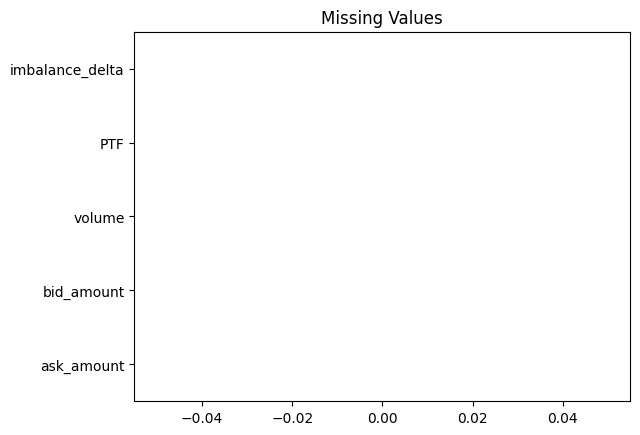

In [118]:
# controlling for missing values
comb.isnull().sum().plot(kind="barh");plt.title("Missing Values");
comb.tail()

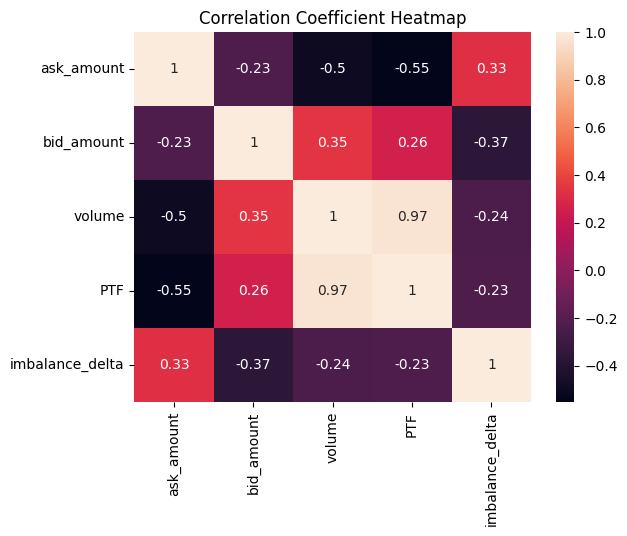

In [119]:
# variable coefficient heatmap
sns.heatmap(comb.corr(), annot=True);plt.title("Correlation Coefficient Heatmap");

# ML Modelling 🤖
*  Baseline XGBRegressor
*  XGBRegressor With Hyperparameter Tuning

A baseline XGBM regression model is built for later root mean squared error(rmse) performance benchmark. The main strategy followed when building XGBM model is as follows;

$\hat{y}_{(t)} = a_{1} + w_{11}*y_1(t-1) + w_{12}*y_2(t-1) + w_{13}*y_3(t-1) + w_{14}*y_4(t-1) + e_2(t-1)$ 

Where;
* $a_1$: Constant term
* $w_{11}, w_{12}, w_{13}, w_{14}$: Coefficients
* $e_1$: Error term

**The variables used are as follows;**

|Variable|Description|
|--------|-----------|
| PTF|Piyasa takas fiyatı|
| Volume| İşlem Hacmi|
| bid_amount| Teklif edilen alış miktarları|
| ask_amount| Teklif edilen satış miktarları|
| imbalance_delta| Pozitif ve negative dengesizlik miktarlarının deltası|

**Model Strategy**

The strategy relies on exogeneous variables of $lag_1$ when making prediction with the values at time $t-1$ to forecast the value at time $t$. 


In [ ]:
# feature and target variables are separated
X = comb.drop(["PTF"],axis=1)
y = comb["PTF"]
# 80% of all data will be used in training, remaining data will later be used for unseen testing.
cut_off= int(len(X)*0.8)

In [ ]:
# shuffle and split data by 75% training and 25% validation
X_train, X_test, y_train, y_test = train_test_split(X[:cut_off],y[:cut_off], 
                                                    test_size=0.25, shuffle=True)

## Baseline Model

In [ ]:
# XGBM Baseline Model Performance
xgbm = XGBRegressor(random_state=42)
xgbm.fit(X_train, y_train)
xgbm_pred = xgbm.predict(X_test)
xgbm_rmse = (MSE(y_test, xgbm_pred))**(1/2)
print("XGBM RMSE: {:.2f}".format(xgbm_rmse),"\nr^2: {:.3f}".format(xgbm.score(X_test, y_test)))

XGBM RMSE: 61.42 
r^2: 0.965


## Hyperparameter Tuning w/ XGBM

In [ ]:
# pipeline for DecisionTreeRegressor()
xgbm_pipeline = Pipeline([("RS",RobustScaler(with_scaling=True)),
                          ('XGBM', XGBRegressor(random_state=42))])

# XGBM Hyperparameters
xgbm_parameters = [{"XGBM__max_depth":np.arange(3,30,3),
                    "XGBM__n_estimators":np.arange(100,351,50),
                    "XGBM__learning_rate":np.arange(0.1,0.45,0.05),
                    "XGBM__subsample":np.arange(0.7,0.95,0.05)}]

# RandomizedSearchCV w/ pipeline   
xgbm_rsg = RandomizedSearchCV(estimator=xgbm_pipeline,
                              param_distributions=xgbm_parameters,
                              scoring="neg_mean_squared_error",
                              verbose=1)
# fit and predict
xgbm_rsg.fit(X_train, y_train)
xgbm_rsg_preds = xgbm_rsg.predict(X_test)

# RMSE Score
xgbm_rsg_rmse = (MSE(y_test, xgbm_rsg_preds))**(1/2)

# Model Performance and Best Parameter Selection
print("XGBRegressor RMSE: {:.3f}".format(xgbm_rsg_rmse),
      "\nBest Parameters: {}".format(xgbm_rsg.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBRegressor RMSE: 59.972 
Best Parameters: {'XGBM__subsample': 0.8, 'XGBM__n_estimators': 150, 'XGBM__max_depth': 3, 'XGBM__learning_rate': 0.1}


## Hyperparameter Tuning Results

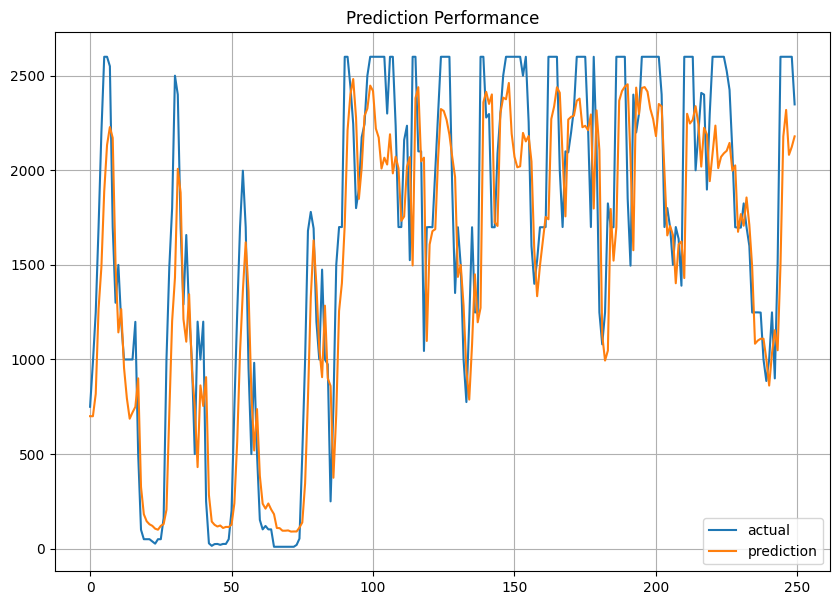

In [ ]:
# Actual vs Predicted Values
actual_pred = xgbm_rsg.predict(X[cut_off:])
plt.figure(figsize=(10,7))
plt.plot(y[-250:].values, label="actual")
plt.plot(actual_pred[-250:], label="prediction")
plt.title("Prediction Performance")
plt.grid()
plt.legend();

In [ ]:
current_data = {"ask_amount":25070.30,"bid_amount":21246.70,"volume":36585255.25,"imbalance_delta":0}
current_data_df = pd.DataFrame([current_data])
current_prediction = xgbm_rsg.predict(current_data_df)

In [ ]:
current_prediction[0]

1927.7911

actual value was 2.099,99 (TL/Mwh)

# Time-Series Forecast 📈

*  The model architecture is built upon various layers including, LSTM, Dense, BatchNormalization, and Dropout.

*  LSTMs are a type of recurrent neural network (RNN) that are designed to effectively capture long-term dependencies in sequential data. They are particularly useful when dealing with sequences that have long-range dependencies, where information from distant past or future time steps can significantly impact the current prediction. LSTMs achieve this by using a memory cell and a set of gates that control the flow of information within the network.

**Additional Layers**
*  BatchNormalization: Batch Norm is a normalization technique done between the layers of a Neural Network instead of in the raw data. It is done along mini-batches instead of the full data set. It serves to speed up training and use higher learning rates, making learning easier. 
$$z^N = (z-m_z)/s_z$$

*  Dropout: Dropout is a regularization method approximating concurrent training of many neural networks with various designs. During training, some layer outputs are ignored or dropped at random. This makes the layer appear and is regarded as having a different number of nodes and connectedness to the preceding layer. Adding a Dropout layer also helps overfitting by eliminating some nodes with vanishing gradient descent (dead-neuron) issue and not transfer empty nodes for later back-ward propagation weight optimizations.

*  Dense: A Dense layer, also known as a fully connected layer, is commonly used after the LSTM layer. The Dense layer is responsible for transforming the output of the LSTM layer into a suitable format for the specific task at hand. It performs a linear transformation followed by a non-linear activation function on the input data, allowing the model to learn complex patterns and make predictions based on the transformed representation.           



## Performance Metrics

In [120]:
def evaluate_preds(y_test, y_pred):
  """
  Description:
  ------------
  Evaluates the performance of predicted values against the true values using various metrics.

  Parameters:
  -----------
  y_test: array-like
      True values of the target variable.
  y_pred: array-like
      Predicted values of the target variable.

  Returns:
  --------
  dict:
      A dictionary containing the calculated metrics, including Mean Absolute Error (MAE),
      Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).
  """
  y_test = tf.cast(y_test, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae=tf.keras.metrics.mean_absolute_error(y_test, y_pred)
  mse=tf.keras.metrics.mean_squared_error(y_test, y_pred)
  rmse=tf.sqrt(mse)
  mape=tf.keras.metrics.mean_absolute_percentage_error(y_test, y_pred)

  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy(),
          "mape":mape.numpy()}

## Callbacks

In [121]:
tf.random.set_seed(42)

# best epoch 
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/model-{epoch:02d}-{root_mean_squared_error:.3f}.hdf5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

# learning rate drop
cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    mode="min",
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=0.000001
)

# early stopping
cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    min_delta=0.001,
    patience=10,
    verbose=1,
)

# CSV logger
cb_csvlogger = tf.keras.callbacks.CSVLogger(
    filename="training_log.csv",
    separator=",",
    append=False   
)

## Model Preparation

In [122]:
ptf_copy = comb.copy()
for i in range(48):
  ptf_copy[f"PTF+{i+1}"] = ptf_copy["PTF"].shift(periods=i+1)
ptf_copy.head()

,ask_amount,bid_amount,volume,PTF,imbalance_delta,PTF+1,PTF+2,PTF+3,PTF+4,PTF+5,...,PTF+39,PTF+40,PTF+41,PTF+42,PTF+43,PTF+44,PTF+45,PTF+46,PTF+47,PTF+48
1,27162.1,15061.6,2308591.87,205.34,1306.22,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27757.1,14529.6,2138249.68,164.94,470.74,205.34,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28790.3,14143.6,1716019.04,154.52,450.79,164.94,205.34,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29594.3,13665.6,1539540.76,112.64,601.44,154.52,164.94,205.34,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,30011.2,13511.2,1164361.96,105.02,492.87,112.64,154.52,164.94,205.34,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
X = ptf_copy.dropna().drop(["PTF"],axis=1).astype(np.float32)
y = ptf_copy.dropna()["PTF"].astype(np.float32)
X.head()

,ask_amount,bid_amount,volume,imbalance_delta,PTF+1,PTF+2,PTF+3,PTF+4,PTF+5,PTF+6,...,PTF+39,PTF+40,PTF+41,PTF+42,PTF+43,PTF+44,PTF+45,PTF+46,PTF+47,PTF+48
49,30969.099609,20929.000000,2623939.00,960.739990,195.009995,169.910004,174.119995,182.990005,141.000000,182.050003,...,204.000000,193.270004,152.899994,119.889999,85.000000,105.019997,112.639999,154.520004,164.940002,205.339996
50,32707.599609,20487.300781,2410817.00,633.530029,179.130005,195.009995,169.910004,174.119995,182.990005,141.000000,...,169.990005,204.000000,193.270004,152.899994,119.889999,85.000000,105.019997,112.639999,154.520004,164.940002
51,33463.101562,20161.900391,2042677.00,687.820007,141.660004,179.130005,195.009995,169.910004,174.119995,182.990005,...,145.000000,169.990005,204.000000,193.270004,152.899994,119.889999,85.000000,105.019997,112.639999,154.520004
52,33910.601562,19745.900391,1856058.00,800.080017,130.000000,141.660004,179.130005,195.009995,169.910004,174.119995,...,169.990005,145.000000,169.990005,204.000000,193.270004,152.899994,119.889999,85.000000,105.019997,112.639999
53,34095.398438,19687.500000,1851811.75,889.780029,129.990005,130.000000,141.660004,179.130005,195.009995,169.910004,...,169.990005,169.990005,145.000000,169.990005,204.000000,193.270004,152.899994,119.889999,85.000000,105.019997


In [124]:
# divide training and unseen data 
split_size = int(len(X) *0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


## Model Architecture

In [125]:
# LSTM model with the Functional API
inputs = layers.Input(shape=(52))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
x = layers.BatchNormalization()(x)
x = layers.LSTM(512, activation="relu", return_sequences=True)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
x = layers.LSTM(512)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(1, activation="linear")(x)
model_lstm = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm")

# compile
model_lstm.compile(loss="mse",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [126]:
model_lstm.summary()

Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 52)]              0         
                                                                 
 lambda_10 (Lambda)          (None, 1, 52)             0         
                                                                 
 batch_normalization_40 (Bat  (None, 1, 52)            208       
 chNormalization)                                                
                                                                 
 lstm_20 (LSTM)              (None, 1, 512)            1157120   
                                                                 
 batch_normalization_41 (Bat  (None, 1, 512)           2048      
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 1, 512)            0

In [127]:
# fit
model_lstm.fit(X_train, y_train,
             epochs=100,
             batch_size=128,
             verbose=0,
             validation_data=(X_test, y_test),
             callbacks=[cb_checkpoint,
                        cb_reducelr,
                        cb_earlystop,
                        cb_csvlogger])


Epoch 1: val_loss improved from inf to 5713046.50000, saving model to checkpoints/model-01-427.582.hdf5

Epoch 2: val_loss improved from 5713046.50000 to 2733428.25000, saving model to checkpoints/model-02-271.597.hdf5

Epoch 3: val_loss improved from 2733428.25000 to 2099803.25000, saving model to checkpoints/model-03-140.292.hdf5

Epoch 4: val_loss improved from 2099803.25000 to 1844180.25000, saving model to checkpoints/model-04-77.477.hdf5

Epoch 5: val_loss improved from 1844180.25000 to 1604413.62500, saving model to checkpoints/model-05-69.251.hdf5

Epoch 6: val_loss improved from 1604413.62500 to 1556090.87500, saving model to checkpoints/model-06-66.127.hdf5

Epoch 7: val_loss improved from 1556090.87500 to 1490038.75000, saving model to checkpoints/model-07-68.626.hdf5

Epoch 8: val_loss improved from 1490038.75000 to 1352668.37500, saving model to checkpoints/model-08-65.808.hdf5

Epoch 9: val_loss did not improve from 1352668.37500

Epoch 10: val_loss did not improve from 

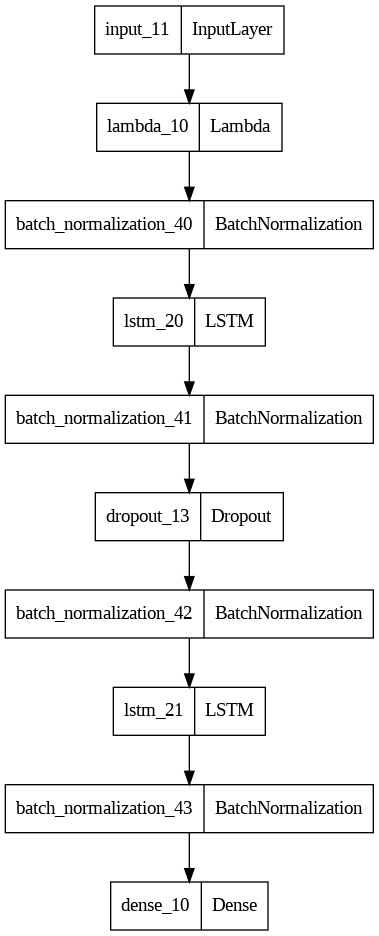

In [128]:
# Plot Model Architecture
plot_model(model_lstm, to_file='model_lstm.png')

## LSTM Model Performance

In [129]:
best_lstm_model = tf.keras.models.load_model("/content/checkpoints/model-26-57.348.hdf5")
model_lstm_preds = tf.squeeze(best_lstm_model.predict(X[split_size:]))
predictions = model_lstm_preds.numpy()

292/292 [==============================] - 7s 20ms/step


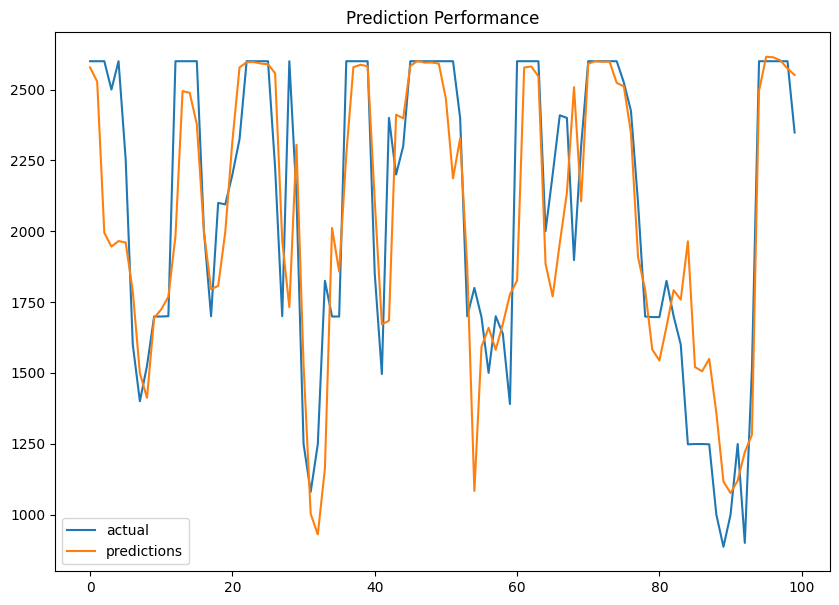

In [132]:
plt.figure(figsize=(10,7))
plt.plot(y[-100:].values, label="actual")
plt.plot(predictions[-100:], label="predictions")
plt.title("Prediction Performance")
plt.legend();

# Conclusion

To conclude, Fine-tuned XGBM model appear to reveal less accruate results at capturing time-variant dependencies with $lag_1$-exogenous variables than nn.LSTM. Further improvments may include but not be limited to; 

* Continuing hyperparameter tuning with wider ranges yet miniscule intervals. 
* Adding additional layers, such as Dropout, LSTM, or Dense.
* More data may put forth additional robustness for later models.
* Better feature variables would add further model performance.

|Model|RMSE| 
|------|-----|
|Fine-tuned XGBM| 59.972|
|nn.LSTM| 57.348| 